In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier

np.random.seed(42)
dataset = pd.read_csv('HotDatasetS.csv')

Split 'Mental Health Score' into multiple categories of Mental Health

In [2]:
min_score = dataset['Mental health score'].min()
max_score = dataset['Mental health score'].max()
new_bins = [min_score, -1.5, -0.5, 0.5, max_score]
new_labels = ['Very low', 'Low', 'Moderate', 'High']
dataset['Mental health category'] = pd.cut(dataset['Mental health score'], bins=new_bins, labels=new_labels)

X = dataset.drop(['Mental health score', 'Mental health category'], axis=1) # X is the feature
y = dataset['Mental health category'] # y is the target variable
dataset

,Age,Hours per day,BPM,Anxiety,Depression,Insomnia,OCD,Mental health score,Primary streaming service_Apple Music,Primary streaming service_I do not use a streaming service.,...,Frequency [Rock]_Sometimes,Frequency [Rock]_Very frequently,Frequency [Video game music]_Never,Frequency [Video game music]_Rarely,Frequency [Video game music]_Sometimes,Frequency [Video game music]_Very frequently,Music effects_Improve,Music effects_No effect,Music effects_Worsen,Mental health category
0,-0.598806,0.159501,0.287691,0.406500,0.703560,2.012666,-0.226903,1.086242,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,-0.620174,-0.589015,2.366432,-1.759702,1.889241,-0.160956,Moderate
1,3.356381,-0.408280,-1.272932,1.134341,0.703560,-0.253729,0.125004,0.591815,-0.272289,-0.312996,...,-0.648886,-0.912871,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,Moderate
2,-0.598806,0.159501,-0.525134,0.406500,-0.972120,0.393812,2.236451,0.715421,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,1.612452,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,Moderate
3,-0.598806,0.538022,-1.207906,0.770420,1.038696,1.041354,1.532635,1.580669,-0.272289,-0.312996,...,-0.648886,1.095445,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,High
4,-0.598806,-0.219019,-1.858165,-0.685261,1.038696,0.717583,-0.930719,0.097387,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,-0.690787,-0.597540,-0.102465,0.406500,0.368424,-1.225042,2.236451,0.591815,-0.272289,-0.312996,...,-0.648886,1.095445,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,Moderate
590,-0.598806,-0.976060,1.198054,-1.049181,-0.972120,-0.577500,0.828820,-0.644254,-0.272289,-0.312996,...,1.541104,-0.912871,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956,Low
591,-0.506825,0.916542,-0.102465,-1.413101,-0.972120,-0.577500,-0.226903,-1.138681,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,1.612452,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,Very low
592,-0.506825,0.538022,1.523183,-1.413101,-0.636984,-0.577500,-0.578811,-1.138681,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956,Very low


Create pipelines and split training/testing/validation sets

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)
# Encoded a unique value to the categories, such that
# 0 - [Zero Category]
# 1 - [Very Low 0-10]
# 2 - [Low 10-20]
# 3 - [Moderate 20-30]
# 4 - [High 30-40]

# Split the dataset into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# Splitting test set in half, one half remains in test set and the other goes to the validation set

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # SimpleImputer replaces all missing values with the median
    ('scaler', StandardScaler())])
    # StandardScaler makes each feature have a standard deviation of 1 and a mean of 0

    # NOTE: StandardScaler does not modify the data, it only transforms it to be easier to read by a Machine Learning model.
    # This means the data sent into the model is the exact same as the dataset, only its been standardized
    # More info on https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # This instance of SimpleImputer replaces missing values with the one that appears most frequently
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    # Performs OneHotEncoding on categorical values in X
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', GaussianNB())])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Hours per day', 'BPM', 'Anxiety', 'Depression', 'Insomnia',
       'OCD', 'Primary streaming service_Apple Music',
       'Primary streaming service_I do not use a streaming service.',
       'Primary streaming service...
       'Frequency [Video game music]_Sometimes',
       'Frequency [Video game music]_Very frequently', 'Music effects_Improve',
       'Music effects_No effect', 'Music effects_Worsen'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('classifier', GaussianNB())])

Predict on Testing Set

In [4]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy *= 100
print("Naive Bayes Testing Set Metrics:")
print("Accuracy: ", accuracy, "%", sep="")

Naive Bayes Testing Set Metrics:
Accuracy: 17.97752808988764%


Predict on Validation Set

In [5]:
y_pred_valid = pipeline.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
accuracy_valid *= 100
print("Naive Bayes Validation Set Metrics:")
print("Accuracy: ", accuracy_valid, "%", sep="")

Naive Bayes Validation Set Metrics:
Accuracy: 23.333333333333332%


In [6]:
X_test

,Age,Hours per day,BPM,Anxiety,Depression,Insomnia,OCD,Primary streaming service_Apple Music,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,...,Frequency [Rock]_Rarely,Frequency [Rock]_Sometimes,Frequency [Rock]_Very frequently,Frequency [Video game music]_Never,Frequency [Video game music]_Rarely,Frequency [Video game music]_Sometimes,Frequency [Video game music]_Very frequently,Music effects_Improve,Music effects_No effect,Music effects_Worsen
585,0.137043,-0.976060,0.417742,-2.140942,-1.642393,-1.225042,-0.930719,-0.272289,-0.312996,-0.265085,...,-0.37432,-0.648886,-0.912871,-0.675191,1.612452,-0.589015,-0.422577,-1.759702,1.889241,-0.160956
218,-0.414844,-0.219019,-0.134978,0.770420,-0.301848,-0.253729,0.476912,-0.272289,-0.312996,-0.265085,...,-0.37432,1.541104,-0.912871,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956
92,1.516759,-0.219019,-0.330056,1.134341,0.703560,0.717583,-0.226903,-0.272289,-0.312996,-0.265085,...,-0.37432,-0.648886,1.095445,1.481063,-0.620174,-0.589015,-0.422577,-1.759702,1.889241,-0.160956
356,-0.322863,-0.976060,0.385229,-1.049181,-1.642393,-0.577500,-0.930719,-0.272289,-0.312996,-0.265085,...,-0.37432,-0.648886,-0.912871,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956
582,-0.782768,0.916542,-0.590160,1.498261,0.703560,0.717583,2.588358,-0.272289,-0.312996,-0.265085,...,-0.37432,-0.648886,-0.912871,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0.688929,-0.597540,-1.272932,-0.685261,-0.636984,-0.901271,1.180727,-0.272289,-0.312996,-0.265085,...,-0.37432,1.541104,-0.912871,-0.675191,-0.620174,-0.589015,2.366432,0.568278,-0.529313,-0.160956
533,-0.690787,0.159501,-0.102465,-0.685261,-0.972120,-1.225042,-0.930719,-0.272289,-0.312996,-0.265085,...,-0.37432,-0.648886,1.095445,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956
101,-0.138901,-0.597540,-0.200004,0.406500,-0.636984,-0.577500,0.125004,-0.272289,-0.312996,-0.265085,...,-0.37432,1.541104,-0.912871,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956
163,0.780910,1.295063,0.352716,1.134341,-0.636984,1.041354,1.884543,-0.272289,-0.312996,-0.265085,...,-0.37432,-0.648886,1.095445,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956


In [7]:
print(y_test)

# NOTE: 0 - [Zero Category]
#       1 - [Very Low 0-10]
#       2 - [Low 10-20]
#       3 - [Moderate 20-30]
#       4 - [High 30-40]

[4 1 2 3 0 1 1 1 1 2 2 0 2 1 2 2 1 1 2 1 2 2 2 1 1 1 1 3 1 3 1 2 3 2 1 2 2
 3 2 2 2 2 3 1 2 3 2 2 3 2 1 3 2 3 1 3 3 1 1 1 1 1 1 3 3 3 2 1 2 3 3 0 1 1
 1 3 3 1 3 2 3 2 1 2 1 3 1 2 2]


In [8]:
print(y_pred)

# NOTE: 0 - [Zero Category]
#       1 - [Very Low 0-10]
#       2 - [Low 10-20]
#       3 - [Moderate 20-30]
#       4 - [High 30-40]

[3 3 0 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 1 0 3 0 3 0 1 3 0 0 0 0
 0 0 3 0 0 0 0 0 0 0 0 3 0 0 3 2 3 0 3 0 0 0 0 0 0 0 0 0 3 0 0 0 3 3 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]


Classification Report

In [9]:
print("Classification Report for Gaussian Naive Bayes Classifier:")
labels = ['Extremely Low','Very low', 'Low', 'Moderate', 'High']
print(classification_report(y_test, y_pred, target_names=labels))

Classification Report for Gaussian Naive Bayes Classifier:
               precision    recall  f1-score   support

Extremely Low       0.03      0.67      0.06         3
     Very low       0.50      0.03      0.06        33
          Low       0.67      0.07      0.12        30
     Moderate       0.73      0.50      0.59        22
         High       0.00      0.00      0.00         1

     accuracy                           0.18        89
    macro avg       0.39      0.25      0.17        89
 weighted avg       0.59      0.18      0.21        89



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Table comparing actual value to predicted value

In [10]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
reg_model_diff

,Actual value,Predicted value
0,4,3
1,1,3
2,2,0
3,3,3
4,0,2
...,...,...
84,1,0
85,3,0
86,1,0
87,2,0


Scatter plot showing the above table

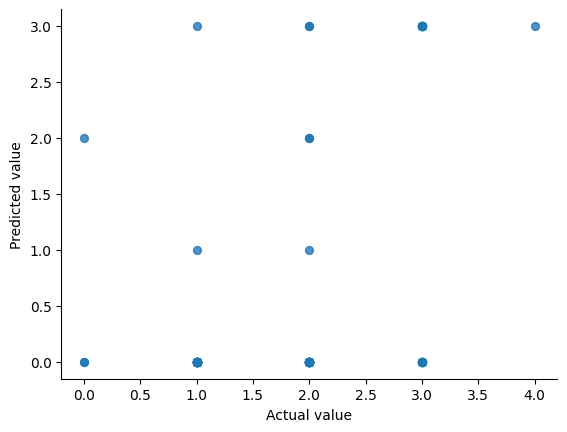

In [11]:
reg_model_diff.plot(kind='scatter', x='Actual value', y='Predicted value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Confusion Matrix

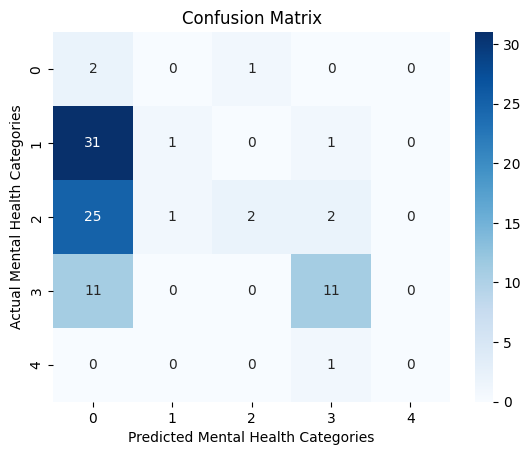

In [12]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Mental Health Categories')
plt.ylabel('Actual Mental Health Categories')
plt.title('Confusion Matrix')
plt.show()